I am trying to analyze data thru diff views to get a clue which features may be impacting target. My intenetion is to keep things simple and easily comprehendable. I myself get lost sometimes in good kernels which are bit low on structure part.  I have tried to keep it structured and scalable for new features and models. 

-  [Import and Read](#LibLink)
-  [Basic EDA](#EDALink)
-  [Functions](#FuncLink)
-  [Plotting](#PlotLink)
-  [Corr and Bin](#CorLink)
-  [Features](#FeatLink)
-  [Model](#ModLink)

<div id="LibLink">
**Import libraries**
</div>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from scipy.stats import rankdata
import lightgbm as lgb
from sklearn import metrics
import gc
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn import metrics
from scipy.stats import norm, rankdata
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', 200)
# below is to have multiple outputs from same Jupyter cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')
from feature_selector import FeatureSelector

Read files 

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
train_df = train_df.sample(n = 20000, random_state = 42)
test_df = test_df.sample(n = 20000, random_state = 42)

<div id="EDALink">
 **Basic EDA**
 </div>

Number of rows and columns in Dataset

In [4]:
print("Train Shape\n")
print("*"*80)
train_df.shape
print("*"*80)
print("Test Shape\n")
print("*"*80)
test_df.shape

Train Shape

********************************************************************************


(20000, 202)

********************************************************************************
Test Shape

********************************************************************************


(20000, 201)

Basic statistics for datasets

In [5]:
print("Train Describe\n")
train_df.describe() 
print("Test Describe\n")
test_df.describe()

Train Describe



,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000

Test Describe



,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0

Distribution of target in training dataset. This shows its a imbalance data set, with 90% of data being 0 and 10% as 1.

0    89.835
1    10.165
Name: target, dtype: float64

[Text(0,0.5,'Count'), Text(0.5,0,'Target'), Text(0.5,1,'Target Distribution')]

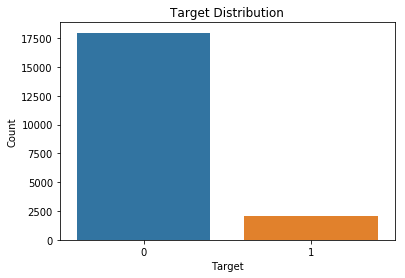

In [6]:
train_df["target"].value_counts()/train_df.shape[0]*100
fig,ax= plt.subplots()
sns.countplot(data=train_df,x="target",ax=ax)
ax.set(xlabel="Target",
       ylabel="Count", 
       Title = "Target Distribution"
       )

Looking at output of describe for both df, data seems to be similar in both the datasets (test and train).  Another point is test is of same size as train. we need to find a way to extract some info from test data.

### Missing values

None of dataset has any missing values. 

In [7]:
train_df.isnull().sum().sum()
test_df.isnull().sum().sum()

0

0

<div id="FuncLink">
** Utility Functions for EDA and Feature Engineering **
    </div>

To reduce memory footprint

In [8]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()/2.0
            c_max = df[col].max()/2.0
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

To plot distributions features of two datasets  **plot_feature_distribution**

In [9]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

To plot boxplot of features of two datasets, along with class split  **plot_feature_boxplot**

In [10]:
def plot_feature_boxplot(df1,df2,label1,label2,features,target):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(100,2,figsize=(10,180))

    for feature in features:
        i += 1
        plt.subplot(100,2,i)
        sns.boxplot(y=df1[feature], x=target, showfliers=False)
        plt.title(feature+'_train', fontsize=10)
        plt.ylabel('')
        plt.xlabel('')
        i += 1
        plt.subplot(100,2,i)
        sns.boxplot(df2[feature],orient='v',color='r')
        plt.title(feature+'_test', fontsize=10)
        plt.ylabel('')
        plt.xlabel('')

        #locs, labels = plt.xticks()
        #plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        #plt.tick_params(axis='y', which='major', labelsize=6)
        #plt.gca().axes.get_xaxis().set_visible(False)
        #plt.gca().axes.get_yaxis().set_visible(False)
    plt.tight_layout()  
    plt.show();
    
    

To plot violinplot of features of two datasets, along with class split  **plot_feature_violinplot**

In [11]:
def plot_feature_violinplot(df1,df2,label1,label2,features,target):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(100,2,figsize=(10,180))

    for feature in features:
        i += 1
        plt.subplot(100,2,i)
        sns.violinplot(y=df1[feature], x=target, showfliers=False)
        plt.title(feature+'_train', fontsize=10)
        plt.ylabel('')
        plt.xlabel('')
        i += 1
        plt.subplot(100,2,i)
        sns.violinplot(df2[feature],orient='v',color='r')
        plt.title(feature+'_test', fontsize=10)
        plt.ylabel('')
        plt.xlabel('')

        #locs, labels = plt.xticks()
        #plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        #plt.tick_params(axis='y', which='major', labelsize=6)
        #plt.gca().axes.get_xaxis().set_visible(False)
        #plt.gca().axes.get_yaxis().set_visible(False)
    plt.tight_layout()  
    plt.show();
    

To plot violinplot of binned features for training along with class split  **plot_binned_feature_target_violinplot**

In [12]:
def plot_binned_feature_target_violinplot(df,features,target):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(200,1,figsize=(8,380))

    for feature in features:
        bins = np.nanpercentile(df[feature], range(0,101,10))
        df[feature+"_binned"] = pd.cut(df[feature],bins=bins)
        i += 1
        plt.subplot(200,1,i)
        sns.violinplot(y=df[feature+"_binned"], x=target, showfliers=False)
        plt.title(feature+'_binned & Target', fontsize=12)
        plt.ylabel('')
        plt.xlabel('')
       
        locs, labels = plt.xticks()
        plt.xticks([0.0,1.0])
        plt.tick_params(axis='y', which='major', labelsize=8)
        #ax.set_xticks([0.15, 0.68, 0.97])
        #plt.gca().axes.get_xaxis().set_visible(False)
        #plt.gca().axes.get_yaxis().set_visible(False)
    plt.tight_layout()  
    plt.show();

To add new features row wise  **add_new_feature_row**

In [13]:
def add_new_feature_row(df,features):
    for feature in features:
        df[feature+"_pct"] = df[feature].pct_change()
        df[feature+"_diff"] = df[feature].diff()
        df.drop(feature,axis=1)
    return df
    

To normailize features using combined dataset **add_feature_df**

In [14]:
def add_feature_df(df,features):
    # count +ve and -ve
    df['count+'] = np.array(df>0).sum(axis=1)
    df['count-'] = np.array(df<0).sum(axis=1)
    #sum
    #df['sum_outside'] = df.sum(axis=1)
        
    for feature in features:
        #normalize
        #df[feature+'_norm'] = (df[feature] - df[feature].mean())/df[feature].std()
        #percentage change row wise
        #df[feature+"_pct"] = df[feature].pct_change() # didnt give boost
        #diff change row wise
        #df[feature+"_diff"] = df[feature].diff() # didnt give boost
        # Square
        #df[feature+'^2'] = df[feature] * df[feature]
        # Cube
        #df[feature+'^3'] = df[feature] * df[feature] * df[feature]
        # 4th power
        #df[feature+'^4'] = df[feature] * df[feature] * df[feature] * df[feature]
        # Cumulative percentile (not normalized)
        #df[feature+'_cp'] = rankdata(df[feature]).astype('float32')
        # Cumulative normal percentile, probabilites
        #df[feature+'_cnp'] = norm.cdf(df[feature]).astype('float32')
        # sqrt
        #df[feature+'_sqrt'] = np.sqrt(df[feature])
        #binning
        #bins = np.nanpercentile(df[feature], range(0,101,10))
        #df[feature+"_binned"] = pd.cut(df[feature],bins=bins)
        #rounding
        #df[feature+'_r2'] = np.round(df[feature], 2)
        #rounding
        #df['r1_'+feature] = np.round(df[feature], 1)
        #exp
        #df['exp_'+feature] = np.exp(df[feature])
        #exp and feature
        #df['xintoexp_'+feature] = np.exp(df[feature])*df[feature]
        #sum
        #df['sum_inside'] = df[[feature]].sum(axis=1)
        #max
        #df['max'] = df[[feature]].max(axis=1)
        #min
        #df['min'] = df[[feature]].min(axis=1)
        #max
        #df['std'] = df[[feature]].std(axis=1)
        #skew
        #df['skew'] = df[[feature]].skew(axis=1)
        #kurt
        #df['kurt'] = df[[feature]].kurtosis(axis=1)
        #median
        #df['med'] = df[[feature]].median(axis=1)
        #tanh
        df['tanh_'+feature] = np.tanh(df[feature])
        
    return df
    

In [15]:
import gc
gc.collect()

25

<div id = FeatLink>
** Feature Engineering **
    </div>

In [16]:
test_df['target']= np.nan
combine_df = train_df.append(test_df,ignore_index=True)

In [17]:
#features = train_df.columns[~train_df.columns.isin(['target','ID_code'])]
#combine_df = add_feature_df(combine_df,features)

In [18]:
#combine_df.head()

Separate out train and test. Append new features created to training dataset.

In [19]:
train_df = combine_df[combine_df['target'].notnull()].reset_index(drop=True)
test_df = combine_df[combine_df['target'].isnull()].reset_index(drop=True)


In [20]:
# features will have added cols defined as part of feature engineering
features = train_df.columns[~train_df.columns.isin(['target','ID_code'])]

In [21]:
# Features are in train and labels are in train_labels
fs = FeatureSelector(data = train_df[features], labels = train_df["target"])

In [22]:
fs.identify_all(selection_params = {'missing_threshold': 0.6,    
                                    'correlation_threshold': 0.95, 
                                    'task': 'classification',    
                                    'eval_metric': 'auc', 
                                    'cumulative_importance': 0.95})

0 features with greater than 0.60 missing values.

0 features with a single unique value.

0 features with a correlation magnitude greater than 0.95.

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.256918	valid_0's auc: 0.843465
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[273]	valid_0's binary_logloss: 0.259062	valid_0's auc: 0.863868
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[277]	valid_0's binary_logloss: 0.244816	valid_0's auc: 0.867237
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.244109	valid_0's auc: 0.856751
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.246694	valid_0's auc: 0.849056


In [23]:
collinear_features = fs.ops['collinear']
fs.record_collinear.head(10)


,drop_feature,corr_feature,corr_value


In [24]:
fs.feature_importances.head(200)

,feature,importance,normalized_importance,cumulative_importance
0,var_12,101.4,0.012861,0.012861
1,var_33,92.6,0.011745,0.024607
2,var_40,87.3,0.011073,0.035680
3,var_22,84.2,0.010680,0.046360
4,var_146,84.0,0.010654,0.057014
5,var_99,83.4,0.010578,0.067593
6,var_81,83.3,0.010566,0.078158
7,var_34,82.5,0.010464,0.088623
8,var_174,82.3,0.010439,0.099061
9,var_166,81.7,0.010363,0.109424


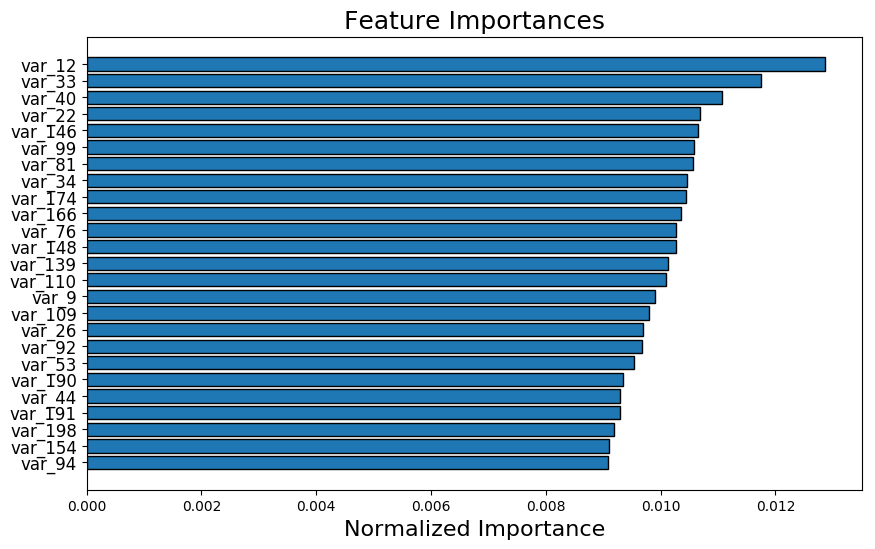

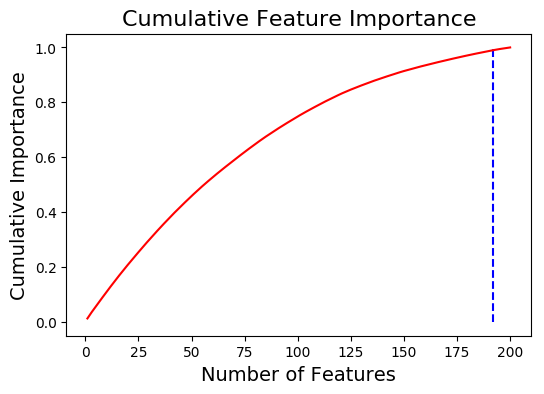

192 features required for 0.99 of cumulative importance


In [25]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 25)

In [26]:
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']
zero_importance_features

[]

In [27]:
train_removed_all = fs.remove(methods = 'all', 
                                          keep_one_hot=False)

['missing', 'single_unique', 'collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 33 features including one-hot features.


In [28]:
fs.ops # stats for which all are removed by what method.

{'missing': [],
 'single_unique': [],
 'collinear': [],
 'zero_importance': [],
 'low_importance': ['var_30',
  'var_69',
  'var_103',
  'var_84',
  'var_189',
  'var_55',
  'var_7',
  'var_117',
  'var_59',
  'var_159',
  'var_10',
  'var_120',
  'var_181',
  'var_19',
  'var_158',
  'var_54',
  'var_136',
  'var_100',
  'var_124',
  'var_61',
  'var_113',
  'var_182',
  'var_47',
  'var_160',
  'var_27',
  'var_3',
  'var_185',
  'var_140',
  'var_96',
  'var_129',
  'var_63',
  'var_42',
  'var_153']}

In [29]:
train_removed_all.head()

,var_0,var_1,var_101,var_102,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_114,var_115,var_116,var_118,var_119,var_12,var_121,var_122,var_123,var_125,var_126,var_127,var_128,var_13,var_130,var_131,var_132,var_133,var_134,var_135,var_137,var_138,var_139,var_14,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_15,var_150,var_151,var_152,var_154,var_155,var_156,var_157,var_16,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_17,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_18,var_180,var_183,var_184,var_186,var_187,var_188,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_2,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_28,var_29,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_4,var_40,var_41,var_43,var_44,var_45,var_46,var_48,var_49,var_5,var_50,var_51,var_52,var_53,var_56,var_57,var_58,var_6,var_60,var_62,var_64,var_65,var_66,var_67,var_68,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_8,var_80,var_81,var_82,var_83,var_85,var_86,var_87,var_88,var_89,var_9,var_90,var_91,var_92,var_93,var_94,var_95,var_97,var_98,var_99
0,11.0038,-4.5026,16.4686,16.2019,12.8148,2.3945,7.4709,8.5071,13.9550,21.1619,-10.8329,9.8180,5.0171,1.0761,3.2167,5.1981,1.9220,-1.2366,-0.1271,14.2550,13.0097,6.8252,-2.2583,12.3314,12.6148,3.3645,-2.3593,3.1023,13.9670,0.6354,9.3048,6.6499,-2.8566,-8.6837,9.9721,-0.2684,14.5387,8.3950,13.3718,5.5494,12.9814,8.9330,-3.7927,10.4264,-2.6617,4.3480,1.3219,14.6973,15.7841,10.0351,7.0457,13.1973,-4.3080,12.4991,3.8944,9.3601,5.8701,6.4919,10.2185,2.0958,21.2336,3.0491,-2.9704,3.1441,6.2050,-16.2458,0.4583,0.0768,15.5984,-4.9126,25.2907,8.1378,-8.2284,8.8929,-4.6192,0.8818,25.2103,-9.0733,7.9633,2.9247,4.4832,-23.8737,11.0638,-0.8200,3.3085,3.1358,5.0959,19.7160,-0.1801,5.8437,8.8348,17.0461,8.8190,9.0662,25.7090,26.2138,3.1250,3.8624,9.8719,13.3379,-0.2924,6.6151,2.6974,10.3559,-4.5293,14.8238,10.7379,-5.9351,-2.7626,3.3004,18.0687,-3.7963,10.7061,1.5211,0.9202,11.7170,5.0610,1.2944,9.4658,5.7952,14.5765,-15.2857,13.1835,15.6327,-5.2194,6.0951,14.5002,6.6383,12.7107,5.1233,8.8871,-4.3664,8.0373,0.1397,5.1969,17.5726,5.0097,15.9658,1.0141,5.7492,26.1362,46.5982,24.0125,13.1818,24.3687,7.4199,13.0182,4.1833,8.7930,12.5658,-13.9001,15.4529,20.2432,-3.0771,10.5996,9.8989,3.4473,8.4055,-10.2275,6.8765,13.1948,10.3968,8.6256,1.0242,20.4547,1.0939,-1.6103
1,12.8473,-6.1848,9.8064,14.2405,13.1557,4.2853,6.1771,27.7338,14.2861,12.1129,4.3768,3.5380,5.6703,2.7019,2.4539,5.4431,0.9963,-2.2788,8.5785,13.9440,12.2097,-11.0140,13.0264,12.4909,12.7370,-0.4456,-7.3313,8.0701,11.5968,1.2320,5.6988,6.9722,-15.0160,2.8469,31.6653,2.4652,16.0949,8.7038,-4.2006,9.2495,15.3238,8.8496,6.2519,12.1683,-9.4692,3.8100,5.2675,14.3273,17.5768,8.1003,6.2566,3.6510,6.7632,12.5633,-3.7928,11.9843,5.9524,3.0484,12.4763,-9.9036,14.4365,3.3320,-7.3907,8.2721,5.1837,-18.4636,-2.7948,2.3001,15.4416,-10.2320,30.5735,8.7345,-4.1818,14.0352,7.3551,1.4468,28.0855,-15.6600,5.7320,29.5496,3.5507,-32.8269,15.5753,1.1516,3.9019,4.6616,7.6035,12.6402,-0.3037,-4.2330,9.7456,14.8337,-3.7167,6.8799,15.4678,38.9225,1.0837,3.9982,9.2248,13.8777,-6.0565,7.0398,-0.1248,10.3549,-3.2378,12.4834,12.5291,2.7469,1.1170,7.3866,14.2286,-4.6728,12.7998,-4.8113,11.3960,11.3417,11.4641,-33.3715,8.2482,9.3439,3.2000,10.2781,11.4987,2.9699,-7.3524,7.6389,13.0295,7.5853,2.8926,4.4191,13.8062,2.5995,5.2267,2.6055,6.6968,16.8178,5.0237,16.0420,0.9583,-2.3364,17.7823,28.7272,13.7785,13.2978,20.5482,6.1629,12.4820,-0.6788,10.6811,10.7930,4.8666,-0.5840,26.2577,-2.5012,7.1703,9.3130,7.5214,8.9070,-32.7268,6.9069,4.9383,11.2197,9.4020,0.0977,-6.3780,2.6695,1.0559
2,13.1827,-0.8344,11.3347,10.5873,12.8472,3.7198,6.4828,11.8917,14.2377,14.6630,-10.2086,3.7862,5.7064,3.8653,3.3894,5.0887,4.8087,-11.4705,-3.8688,13.7723,10.0211,10.1256,4.4105,12.3717,14.3884,2.6725,3.9167,13.6299,11

In [30]:
feat_sel=train_removed_all.columns.values


In [31]:
feat_sel


array(['var_0', 'var_1', 'var_101', 'var_102', 'var_104', 'var_105',
       'var_106', 'var_107', 'var_108', 'var_109', 'var_11', 'var_110',
       'var_111', 'var_112', 'var_114', 'var_115', 'var_116', 'var_118',
       'var_119', 'var_12', 'var_121', 'var_122', 'var_123', 'var_125',
       'var_126', 'var_127', 'var_128', 'var_13', 'var_130', 'var_131',
       'var_132', 'var_133', 'var_134', 'var_135', 'var_137', 'var_138',
       'var_139', 'var_14', 'var_141', 'var_142', 'var_143', 'var_144',
       'var_145', 'var_146', 'var_147', 'var_148', 'var_149', 'var_15',
       'var_150', 'var_151', 'var_152', 'var_154', 'var_155', 'var_156',
       'var_157', 'var_16', 'var_161', 'var_162', 'var_163', 'var_164',
       'var_165', 'var_166', 'var_167', 'var_168', 'var_169', 'var_17',
       'var_170', 'var_171', 'var_172', 'var_173', 'var_174', 'var_175',
       'var_176', 'var_177', 'var_178', 'var_179', 'var_18', 'var_180',
       'var_183', 'var_184', 'var_186', 'var_187', 'var_188', '

In [32]:
with open ("feat_sel.csv","w")as fp:
   for line in feat_sel:
       fp.write(str(line)+"\n")



6

6

8

8

8

8

8

8

8

8

7

8

8

8

8

8

8

8

8

7

8

8

8

8

8

8

8

7

8

8

8

8

8

8

8

8

8

7

8

8

8

8

8

8

8

8

8

7

8

8

8

8

8

8

8

7

8

8

8

8

8

8

8

8

8

7

8

8

8

8

8

8

8

8

8

8

7

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

8

6

7

7

7

7

7

7

7

7

7

7

7

7

7

7

7

7

7

7

6

7

7

7

7

7

7

7

7

6

7

7

7

7

7

7

7

6

7

7

7

7

7

7

7

7

7

7

7

7

7

7

7

7

7

6

7

7

7

7

7

7

7

7

7

6

7

7

7

7

7

7

7

7

7

In [33]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
test_df['target']= np.nan
combine_df = train_df.append(test_df,ignore_index=True)
features = train_df.columns[~train_df.columns.isin(['target','ID_code'])]
combine_df = add_feature_df(combine_df,features)
train_df = combine_df[combine_df['target'].notnull()].reset_index(drop=True)
test_df = combine_df[combine_df['target'].isnull()].reset_index(drop=True)

<div id = ModLink>
** Modeling **
    </div>

This is model lifted and shifted from [Fayaz's](https://www.kaggle.com/fayzur/lightgbm-customer-transaction-prediction) kernel.

In [34]:
#test_df = test_df.drop("target",axis=1)
predictors = train_removed_all.columns
nfold = 5
target = 'target'

In [35]:
'''param = {
     'num_leaves': 18,
     'max_bin': 63,
     'min_data_in_leaf': 5,
     'learning_rate': 0.010614430970330217,
     'min_sum_hessian_in_leaf': 0.0093586657313989123,
     'feature_fraction': 0.056701788569420042,
     'lambda_l1': 0.060222413158420585,
     'lambda_l2': 4.6580550589317573,
     'min_gain_to_split': 0.29588543202055562,
     'max_depth': 49,
     'save_binary': True,
     'seed': 1337,
     'feature_fraction_seed': 1337,
     'bagging_seed': 1337,
     'drop_seed': 1337,
     'data_random_seed': 1337,
     'objective': 'binary',
     'boosting_type': 'gbdt',
     'verbose': 1,
     'metric': 'auc',
     'is_unbalance': True,
     'boost_from_average': False
}
'''
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

nfold = 10

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

i = 1
for train_index, valid_index in skf.split(train_df, train_df.target.values):
    print("\nfold {}".format(i))
    xg_train = lgb.Dataset(train_df.iloc[train_index][predictors].values,
                           label=train_df.iloc[train_index][target].values,
                           feature_name='auto',
                           categorical_feature = 'auto',
                           free_raw_data = False
                           )
    print("after lgb train")
    xg_valid = lgb.Dataset(train_df.iloc[valid_index][predictors].values,
                           label=train_df.iloc[valid_index][target].values,
                           feature_name='auto',
                           categorical_feature = 'auto',
                           free_raw_data = False
                           )   
    print("after lgb test")
    nround = 1000000
    clf = lgb.train(param, 
                    xg_train, 
                    nround, 
                    valid_sets = [xg_train,xg_valid], 
                    early_stopping_rounds=3000,
                    verbose_eval=1000)
    oof[valid_index] = clf.predict(train_df.iloc[valid_index][predictors].values, num_iteration=nround) 
    print("after lgb fit")
    predictions += clf.predict(test_df[predictors], num_iteration=nround) / nfold
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = predictors
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] =  i = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
   


print("\n\nCV AUC: {:<0.4f}".format(metrics.roc_auc_score(train_df.target.values, oof)))


"param = {\n     'num_leaves': 18,\n     'max_bin': 63,\n     'min_data_in_leaf': 5,\n     'learning_rate': 0.010614430970330217,\n     'min_sum_hessian_in_leaf': 0.0093586657313989123,\n     'feature_fraction': 0.056701788569420042,\n     'lambda_l1': 0.060222413158420585,\n     'lambda_l2': 4.6580550589317573,\n     'min_gain_to_split': 0.29588543202055562,\n     'max_depth': 49,\n     'save_binary': True,\n     'seed': 1337,\n     'feature_fraction_seed': 1337,\n     'bagging_seed': 1337,\n     'drop_seed': 1337,\n     'data_random_seed': 1337,\n     'objective': 'binary',\n     'boosting_type': 'gbdt',\n     'verbose': 1,\n     'metric': 'auc',\n     'is_unbalance': True,\n     'boost_from_average': False\n}\n"


fold 1
after lgb train
after lgb test
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.899979	valid_1's auc: 0.884602
[2000]	training's auc: 0.910626	valid_1's auc: 0.892187
[3000]	training's auc: 0.917579	valid_1's auc: 0.895747
[4000]	training's auc: 0.922909	valid_1's auc: 0.897885
[5000]	training's auc: 0.927565	valid_1's auc: 0.899318
[6000]	training's auc: 0.931645	valid_1's auc: 0.899607
[7000]	training's auc: 0.935434	valid_1's auc: 0.899898
[8000]	training's auc: 0.938897	valid_1's auc: 0.900096
[9000]	training's auc: 0.942242	valid_1's auc: 0.900008
[10000]	training's auc: 0.945463	valid_1's auc: 0.899932
Early stopping, best iteration is:
[7492]	training's auc: 0.937164	valid_1's auc: 0.900145
after lgb fit

fold 2
after lgb train
after lgb test
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900115	valid_1's auc: 0.880857
[2000]	training's auc: 0.910671	valid_1's auc: 0.888986
[3000]	training'

Feature Importance as per model

<Figure size 1400x2800 with 0 Axes>

Text(0.5,1,'Features importance (averaged/folds)')

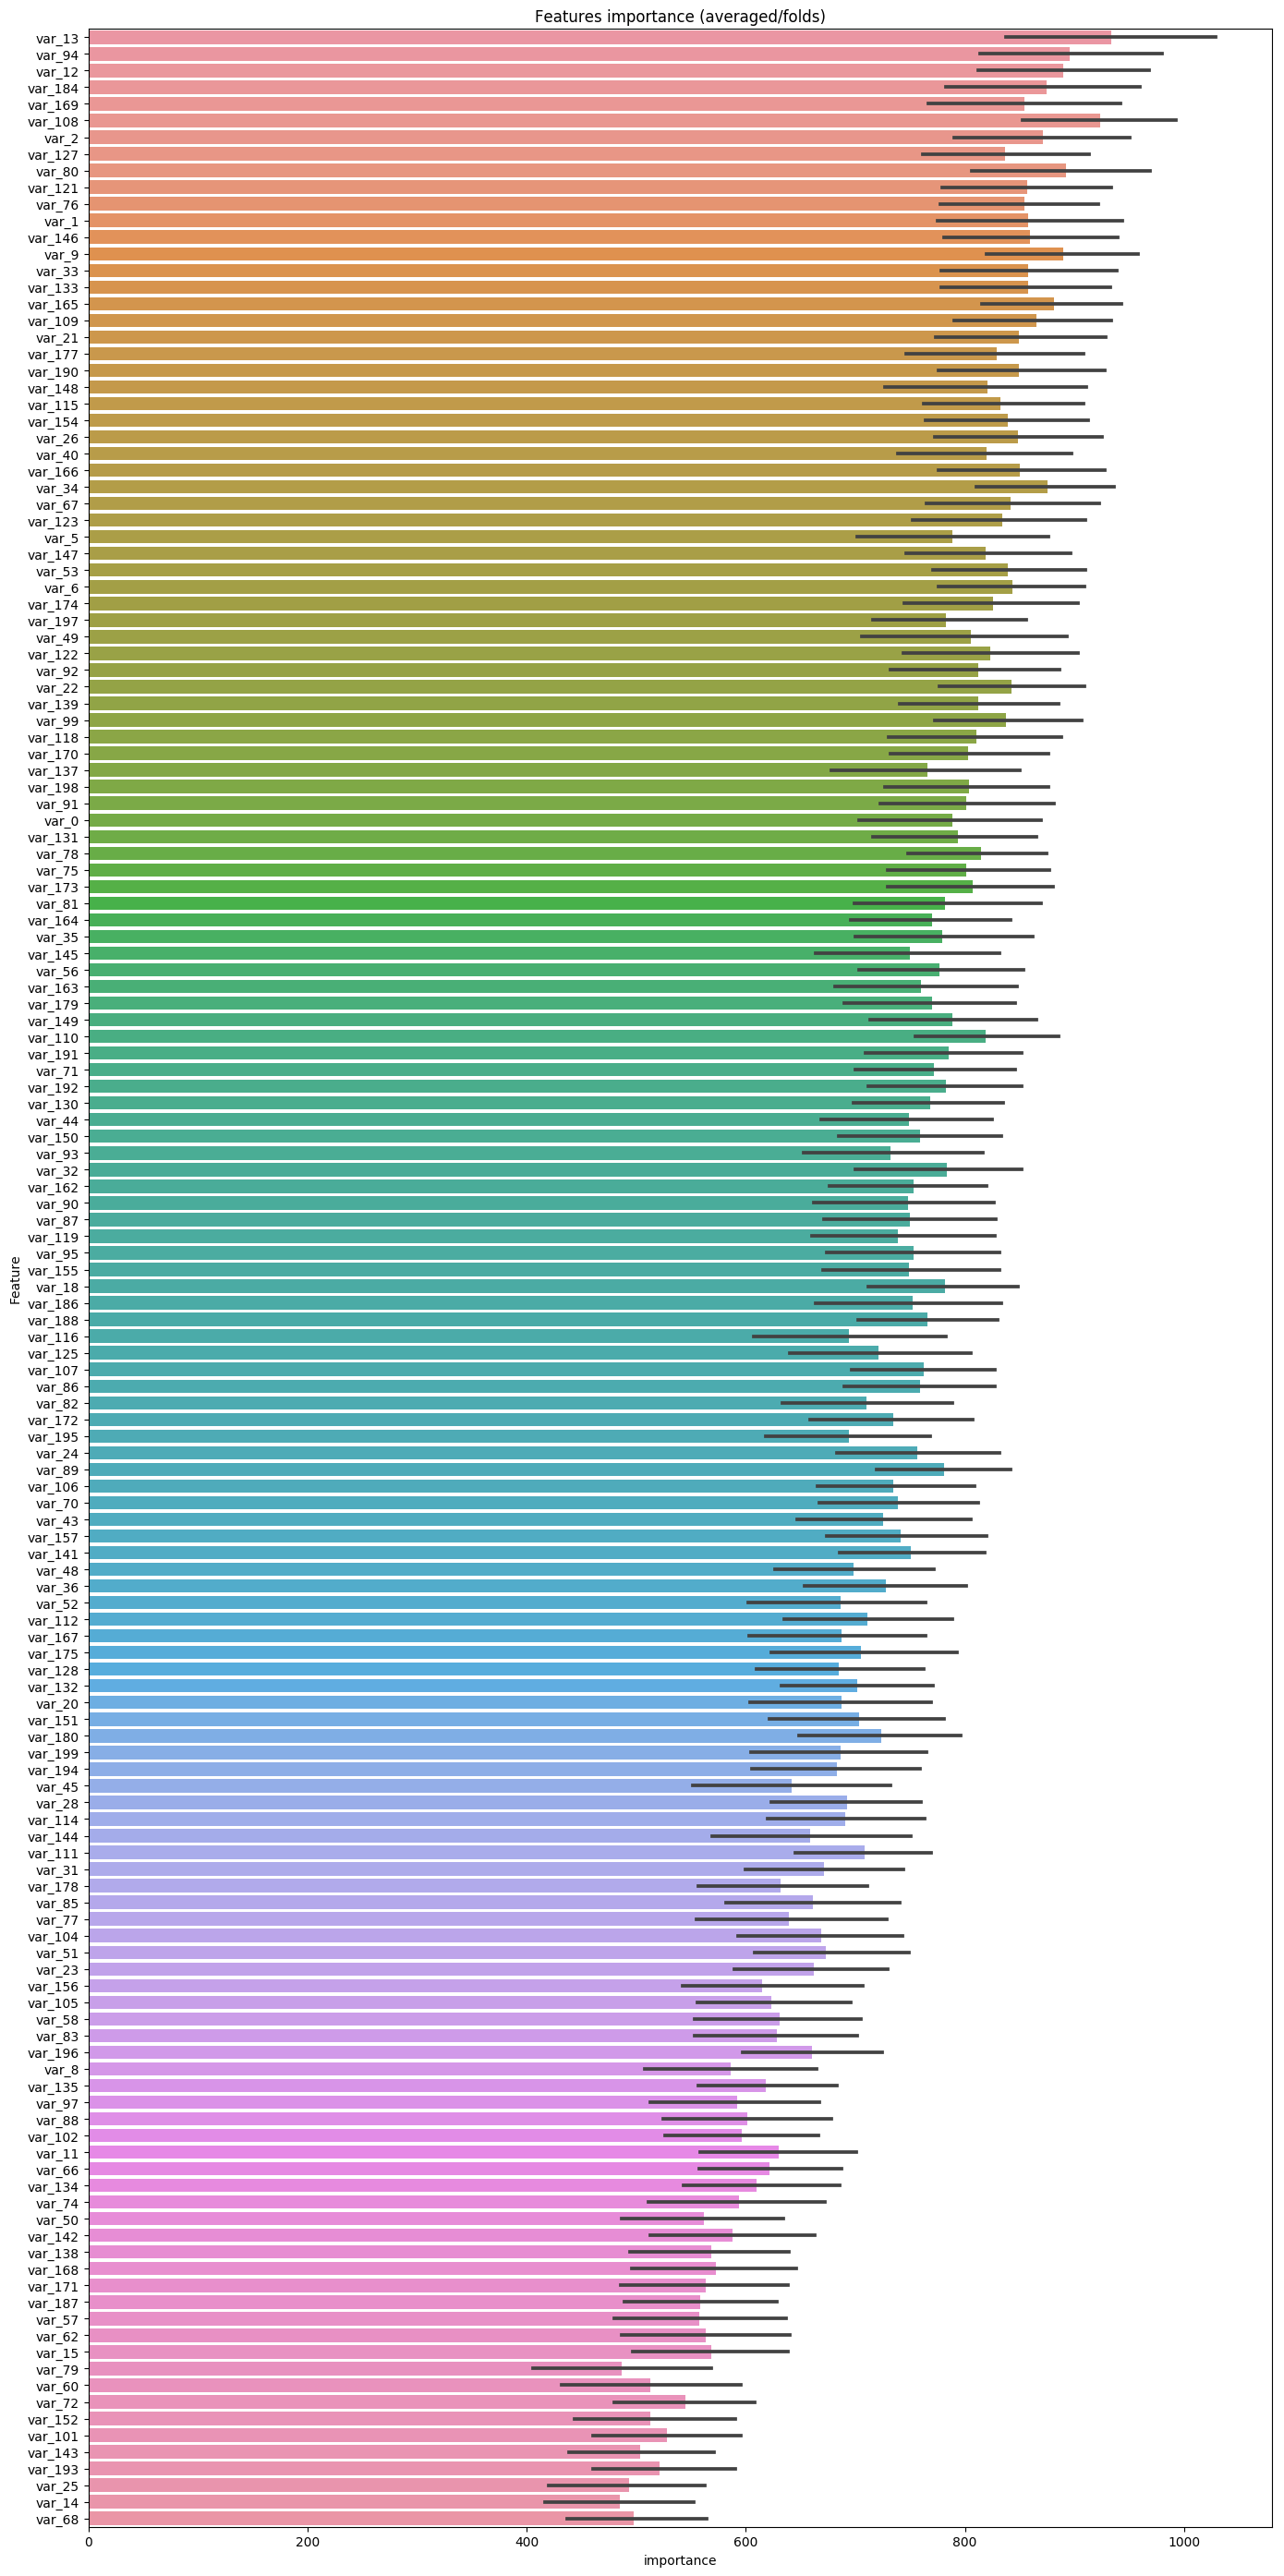

In [36]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [37]:
 # Get feature importances
imp_df = pd.DataFrame()
imp_df["feature"] = predictors
imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
imp_df["importance_split"] = clf.feature_importance(importance_type='split')
imp_df['trn_score'] = roc_auc_score(train_df['target'],clf.predict(train_df.loc[:,predictors]))

In [38]:
imp_df.sort_values(by="importance_gain",ascending=False).to_csv("imp_lgb.csv", index=False)


In [39]:
imp_df.sort_values(by="importance_gain",ascending=False)[:150]

,feature,importance_gain,importance_split,trn_score
149,var_81,32304.051397,855,0.943616
36,var_139,28453.793826,879,0.943616
19,var_12,26437.815088,1024,0.943616
11,var_110,23570.484386,919,0.943616
100,var_26,23205.142894,984,0.943616
125,var_53,23075.336194,918,0.943616
43,var_146,22356.383174,944,0.943616
129,var_6,21351.485260,921,0.943616
96,var_22,21181.999599,944,0.943616
61,var_166,21019.858438,965,0.943616


Submission file

In [40]:
sub_df = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub_df["target"] = predictions
sub_df.to_csv("sant_lgb.csv", index=False)
sub_df[:10]

,ID_code,target
0,test_0,0.097702
1,test_1,0.192965
2,test_2,0.142983
3,test_3,0.197279
4,test_4,0.041002
5,test_5,0.001889
6,test_6,0.004627
7,test_7,0.170169
8,test_8,0.001998
9,test_9,0.008384
